# We can try to have a neural net 'Learn' the filters, that can be used to tranform X into Y. But as we'll see below, these filters will not be pure sine waves, but will have a lot of noise (with frequencies that are absent in the original signal

In [9]:
import numpy as np
import mne
import matplotlib.pyplot as plt

import scipy.io as sio
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
from keras import backend as K
K.set_session(sess)
###################################

from keras.layers import Input, Dense, Conv2D, Conv1D, MaxPooling1D, UpSampling1D, Dropout, BatchNormalization, Flatten
from keras.layers.advanced_activations import LeakyReLU
from keras import regularizers
# act = LeakyReLU(alpha=0.01)

from keras.models import Model, load_model
from keras.callbacks import TensorBoard, EarlyStopping, Callback
from keras import optimizers
from keras.initializers import Orthogonal as orth

def periodogram(fs, X):
    T = X.shape[0]/fs
    t = np.linspace(0.0, T, int(T/(1/fs)))
    yf = fft(X)
    xf = np.linspace(0.0, fs/2.0, int(len(yf)/2))
    yf = 2/(T*fs) * np.abs(yf[0:int(len(yf)/2)])
    return xf, yf

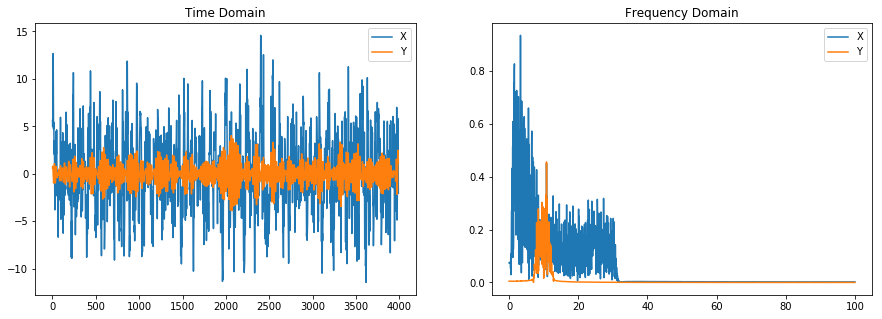

In [13]:
mat_contents = sio.loadmat('/home/amplifier/home/DATASETS/XY.mat')

X = mat_contents['X']
Y = mat_contents['Y']

X = X.reshape(1,32,3991,1)
Y = Y.reshape(1,32,3991,1)

fig = plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(np.squeeze(X[:,14,:,:]))
plt.plot(np.squeeze(Y[:,14,:,:]))
plt.title('Time Domain')
plt.legend(['X', 'Y'])

plt.subplot(1,2,2)
xf1, yf1 = periodogram(fs, X[:,14,:,:].flatten())
xf2, yf2 = periodogram(fs, Y[:,14,:,:].flatten())
plt.plot(xf1, yf1)
plt.plot(xf2, yf2)
plt.title('Frequency Domain')
plt.legend(['X', 'Y'])


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 32, 3991, 1)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 32, 3991, 1)       400       
Total params: 400
Trainable params: 400
Non-trainable params: 0
_________________________________________________________________


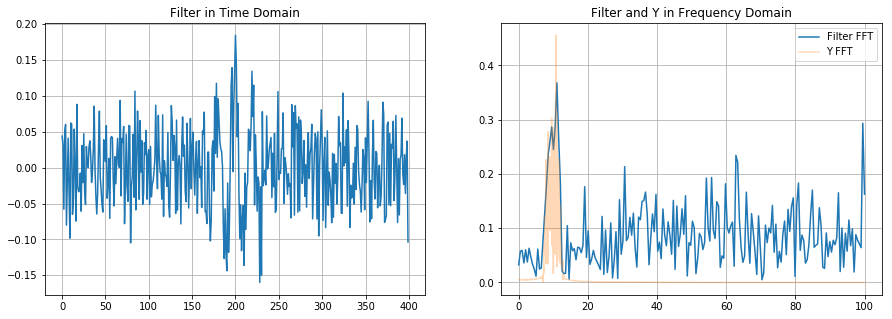

In [21]:
ker_width = 400
inpt = Input(shape=(32, 3991, 1))
l = Conv2D(1, (1,ker_width),
           use_bias=None,
           padding="same",
           activation=None)(inpt)
model = Model(inpt,l)
model.compile(loss='binary_crossentropy', optimizer='adam')
model.summary()

train_history = model.fit(X, Y, epochs=1000, verbose=0)
wts = np.array(model.layers[1].get_weights()).flatten()

fig = plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(wts)
plt.title('Filter in Time Domain')
plt.grid()

plt.subplot(1,2,2)
plt.title('Filter and Y in Frequency Domain')
xf1, yf1 = periodogram(fs, wts)
plt.plot(xf1, 20*yf1)
xf2, yf2 = periodogram(fs, Y[:,14,:,:].flatten())
plt.plot(xf2, yf2, alpha=1.3)
plt.legend(['Filter FFT', 'Y FFT'])
plt.grid()

# Alternatively, we can have the model learn NOT the filters directly (when these filters start to include irrelevant frequencies that don't 'resonate' with the frequencies in the input signal, because these aren't there), but have it learn the filter parameter (i.e. frequency of the sinusoid, or Morlet wavelet). In that case we can get pure (and easily interpretable) filters. The results of this filtering can be combined downstream and/or fed into a FC layer for regression or classification. Keras, as far as I know, can't do it, but PyTorch can:

In [29]:
import torch
from torch.autograd import Variable
import torch.optim as optim
import torch.nn.functional as F
from scipy import signal
from scipy.fftpack import fft
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt

def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

mat_contents = sio.loadmat('/home/amplifier/home/DATASETS/XY.mat')
X = mat_contents['X']
Y = mat_contents['Y']

X = X[:,0:1000]
Y = Y[:,0:1000]


tensor([ 2.,  5., 10., 15., 20.], requires_grad=True)


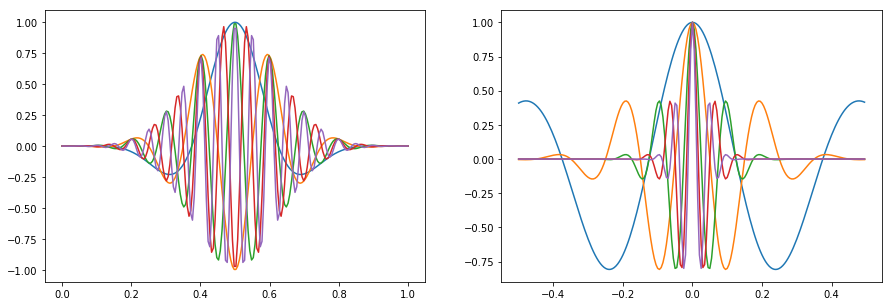

In [30]:
fs = 200
f = Variable(torch.tensor([2.0, 5.0, 10.0, 15.0, 20.0]), requires_grad=True)
print(f)
pi = torch.tensor(np.pi)
T = 1
t = torch.tensor(np.linspace(0.0, T, int(T/(1/fs)), dtype='float32'))


x_values = np.linspace(-4, 4, 200)
g = torch.tensor(gaussian(x_values, 0, 1)).float()

k = []
for i in range(5):
    k.append(g * torch.cos(2.0*pi*f[i]*t))

fig = plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
for i in range(5):
    plt.plot(t.detach().numpy(), k[i].detach().numpy())

t = np.linspace(-T/2, T/2, T * fs, endpoint=False) # sampled @ 200 Hz for 0.5 s
I = []
k_m = []
for j in range(5):
    i, q, e = signal.gausspulse(t, f[j].detach().numpy(), retquad=True, retenv=True)
    I.append(i)
    k_m.append(torch.tensor(i).float())
    
plt.subplot(1,2,2)
for i in range(5):
    plt.plot(t, I[i])

In [31]:
def forward(inputs, f, pi):
    fs = 200
    T = 1
    t = torch.tensor(np.linspace(0.0, T, int(T/(1/fs)), dtype='float32'))
    x_values = np.linspace(-4, 4, 200)
    g = torch.tensor(gaussian(x_values, 0, 1)).float()
    k = []
    for i in range(5):
        k.append(g * torch.cos(2.0*pi*f[i]*t))
    filters = torch.stack(k).view(5,1,1,200)
    x = F.conv2d(inputs, filters, padding=(0,padding))
    return x, filters

inputs.shape =	 torch.Size([1, 1, 32, 1000])
filters.shape =	 torch.Size([5, 1, 1, 200])
filters_m.shape =	 torch.Size([5, 1, 1, 200])
x.shape =	 torch.Size([1, 5, 32, 999])
x_m.shape =	 torch.Size([1, 5, 32, 999])
x_c.shape =	 (5, 1000)


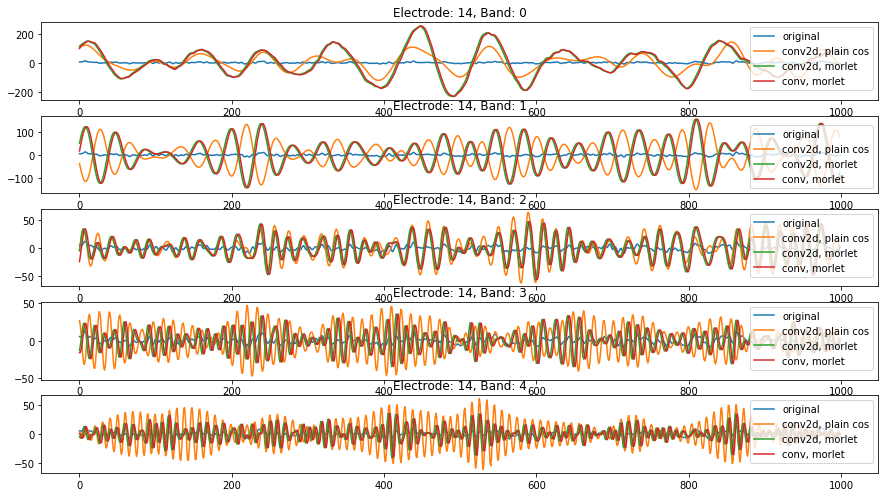

In [32]:
signal_len = X.shape[1]
n_eeg_chans = X.shape[0]
ker_width = 200
padding = 99
n_filters = 5
electrode = 14

inputs = torch.tensor(X).view(1, 1, n_eeg_chans, signal_len) # batch,        in_channels, width

# GET FILTERED SIGNAL AND FILTERS BASED ON SET FREQUENCIES AND USING MY "MORLET" THAT SUPPORTS GRAD:
x, filters = forward(inputs, f, pi)

# GET FILTERED SIGNAL AND FILTERS BASED ON SET FREQUENCIES AND USING MORLET THAT DOESN'T SUPPORT GRAD:
filters_m = torch.stack(k_m).view(5,1,1,200)
x_m = F.conv1d(inputs, filters_m, padding=(0,padding))

# GET FILTERED SIGNAL USING NUMPY'S CONV. JUST TO SEE THAT IT WORKS THE SAME AS TORCH.NN.CONV1D:
x_c = []
for i in range(n_filters):
    x_c.append(np.convolve(X[electrode,:], filters_m[i,0,0,:].detach().numpy().flatten(), mode='same'))
x_c = np.vstack(x_c)

print('inputs.shape =\t', inputs.shape)
print('filters.shape =\t' , filters.shape)
print('filters_m.shape =\t' , filters_m.shape)
print('x.shape =\t', x.shape)
print('x_m.shape =\t', x_m.shape)
print('x_c.shape =\t', x_c.shape)

fig = plt.figure(figsize=(15,10))
for band in range(0, filters.shape[0]):
    plt.subplot(filters.shape[0]+1, 1, band+1)
    plt.plot(X[electrode,:])
    plt.plot(x[0,band,electrode,:].detach().numpy())
    plt.plot(x_m[0,band,electrode,:].detach().numpy())
    plt.plot(x_c[band])
    plt.legend(['original', 'conv2d, plain cos', 'conv2d, morlet', 'conv, morlet'])
    plt.title('Electrode: ' + str(electrode) + ', Band: ' + str(band))

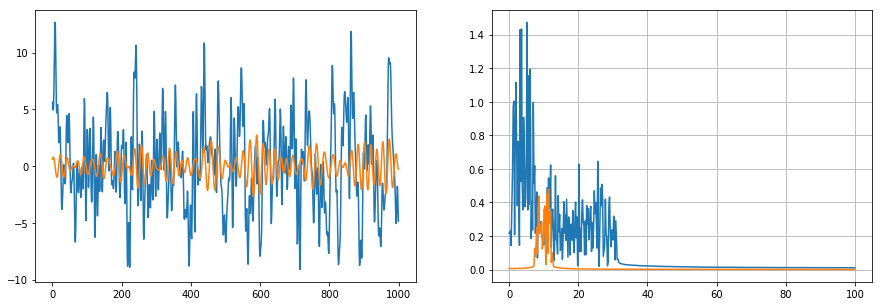

In [33]:
fs = 200.0
xf1, yf1 = periodogram(fs, X[electrode,:])
xf2, yf2 = periodogram(fs, Y[electrode,:])

fig = plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.plot(X[electrode,:])
plt.plot(Y[electrode,:])

plt.subplot(1,2,2)
plt.plot(xf1, yf1)
plt.plot(xf2, yf2)
plt.grid()

In [45]:
optimizer = optim.Adam([f]) # tell the optimizer which var we want optimized
criterion = torch.nn.MSELoss() # set loss type

x, filters = forward(inputs, f, pi) # forward the model to get filtered signal and filters

predictions = torch.sum(x, 1).view(32,-1)
targets = torch.tensor(Y[:,0:999]).float()
loss = criterion(predictions, targets) # compute loss

print('predictions: \trequires_grad?\t', predictions.requires_grad)
print('targets: \trequires_grad?\t', targets.requires_grad)
print('loss: \t\trequires_grad?\t', loss.requires_grad)

predictions: 	requires_grad?	 True
targets: 	requires_grad?	 False
loss: 		requires_grad?	 True


In [44]:
for epoch in range(5000):
    x, filters = forward(inputs, f, pi)
    predictions = torch.sum(x, 1).view(32,-1)
    loss = criterion(predictions, targets)
    loss.backward(retain_graph=True)
    optimizer.step()   # update the variable being optimized (f)       
    optimizer.zero_grad()
    if epoch % 100 == 0:
        print('loss:\t', np.round(loss.item(), 1), '\tfreqs:\t', f)

loss:	 8164.0 	freqs:	 tensor([ 2.0010,  4.9990, 10.0010, 15.0010, 19.9990], requires_grad=True)
loss:	 8115.3 	freqs:	 tensor([ 2.0558,  4.9871, 10.0521, 15.0697, 19.9084], requires_grad=True)
loss:	 8080.7 	freqs:	 tensor([ 2.1268,  5.0512, 10.0597, 15.0460, 19.8152], requires_grad=True)
loss:	 8014.2 	freqs:	 tensor([ 2.2251,  5.1467, 10.0657, 14.9872, 19.6710], requires_grad=True)
loss:	 7952.5 	freqs:	 tensor([ 2.3136,  5.2366, 10.0706, 14.9217, 19.5093], requires_grad=True)
loss:	 7910.7 	freqs:	 tensor([ 2.3792,  5.3039, 10.0713, 14.8631, 19.3543], requires_grad=True)
loss:	 7882.6 	freqs:	 tensor([ 2.4243,  5.3497, 10.0687, 14.8162, 19.2097], requires_grad=True)
loss:	 7860.5 	freqs:	 tensor([ 2.4543,  5.3798, 10.0673, 14.7886, 19.0714], requires_grad=True)
loss:	 7832.6 	freqs:	 tensor([ 2.4749,  5.4010, 10.0841, 14.8265, 18.9190], requires_grad=True)
loss:	 7376.0 	freqs:	 tensor([ 2.5026,  5.4328, 10.2078, 15.2148, 18.6048], requires_grad=True)
loss:	 6906.4 	freqs:	 tensor(

Text(0.5, 1.0, 'Filters after optimization')

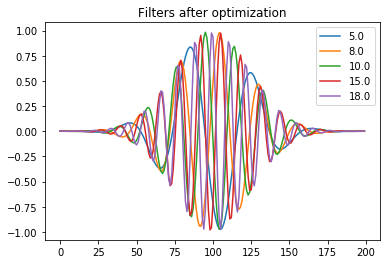

In [65]:
fs = 200
pi = torch.tensor(np.pi)
_, filters = forward(inputs, f, pi)

for i in range(5):
    filt = filters[i,:,:,:].detach().numpy().flatten()
    plt.plot(filt)
plt.legend(f.detach().numpy().round(decimals=0).tolist())
plt.title('Filters after optimization')
    

In [73]:
Y.shape

(32, 1000)

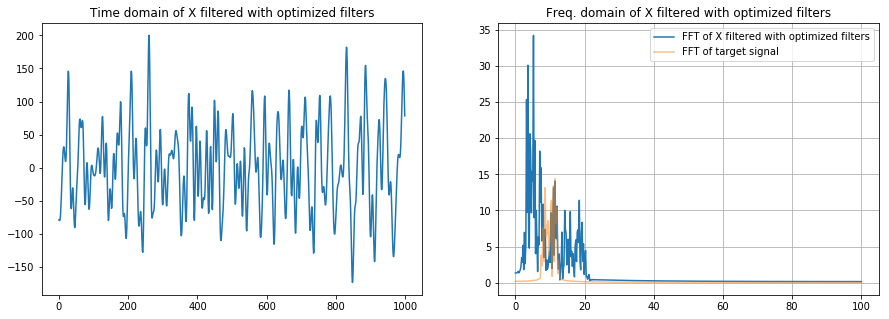

In [78]:
x_ = x[:,:,electrode,:].sum(1).detach().numpy().flatten()

fig = plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(x_)
plt.title('Time domain of X filtered with optimized filters')

plt.subplot(1,2,2)
xf1, yf1 = periodogram(fs, x_)
plt.plot(xf1, yf1)
xf2, yf2 = periodogram(fs, Y[electrode,:].flatten())
plt.plot(xf2, 30*yf2, alpha=0.5)
plt.grid()
plt.title('Freq. domain of X filtered with optimized filters')
plt.legend(['FFT of X filtered with optimized filters', 'FFT of target signal'])

# As we can see, this approach can't fit the target signal very well, but perhaps, if we add weights to each kernel (perhaps an FC layer) we would be able to achieve optimal filters